## Basic ARIMA:
As implied by its shortened acronym, the pure ARIMA model-building methodology employs only lagged values of the dependent variable (i.e., AR terms) and lagged values of errors previously produced by the model (i.e., MA terms). The I in ARIMA refers to integrated and indicates that the dependent variable time series has been differenced one or more times to make the time series stationary before model building begins.

## Introduction to ARIMAX:
An Autoregressive Integrated Moving Average with Explanatory variable (ARIMAX) model is basically an ARIMA model with one or more explanatory/independent variables also known as Exogenous variables.

## Parameters in ARIMAX:
There are basically 3 parameters in an ARIMAX model: p,d,q Values of p and q are determined based on the autocorrelation and partial autocorrelation plots and the value of d depends on the level of stationarity in the data. In PACF plot, the number of spikes, above a certain reference line, decide the value of p. In ACF plot, the number of spikes, above a certain reference line, decide the value of q. For example: ARIMAX(2,1,1) means that we have a second order autoregressive model with first order moving average component and the series has been differenced once to make it stationary.

Let us take a sample dataset of sales and try to understand how ARIMAX works.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
# Import libraries
import warnings
import itertools
import numpy as np

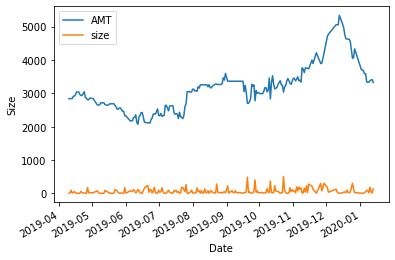

In [2]:
df = pd.read_csv('../Data for Problem C_MCM 2021/0226mean-yingkou-qinzhou.csv')
df['WBL_AUD_DT'] = pd.to_datetime(df['WBL_AUD_DT'],format='%Y-%m-%d')
df.set_index(['WBL_AUD_DT'],inplace=True)

# plot the data
df.plot()
plt.ylabel('Size')
plt.xlabel('Date')
plt.show()

In [3]:
print(sm.tsa.stattools.grangercausalitytests(df[['AMT','size']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.2441 , p=0.0000  , df_denom=227, df_num=1
ssr based chi2 test:   chi2=28.6174 , p=0.0000  , df=1
likelihood ratio test: chi2=26.9722 , p=0.0000  , df=1
parameter F test:         F=28.2441 , p=0.0000  , df_denom=227, df_num=1
{1: ({'ssr_ftest': (28.244091481802386, 2.551671581258346e-07, 227.0, 1), 'ssr_chi2test': (28.617361413279948, 8.818794366173245e-08, 1), 'lrtest': (26.97216700588615, 2.064063327348568e-07, 1), 'params_ftest': (28.244091481802318, 2.55167158125842e-07, 227.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f950da42c50>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f950da42cd0>, array([[0., 1., 0.]])])}


## here is the full blown code for the correct ARIMAX model.

In [4]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [5]:
train_data = df['size'][:204]
test_data = df['size'][204:]

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [7]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 1835.0242379681224 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [8]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

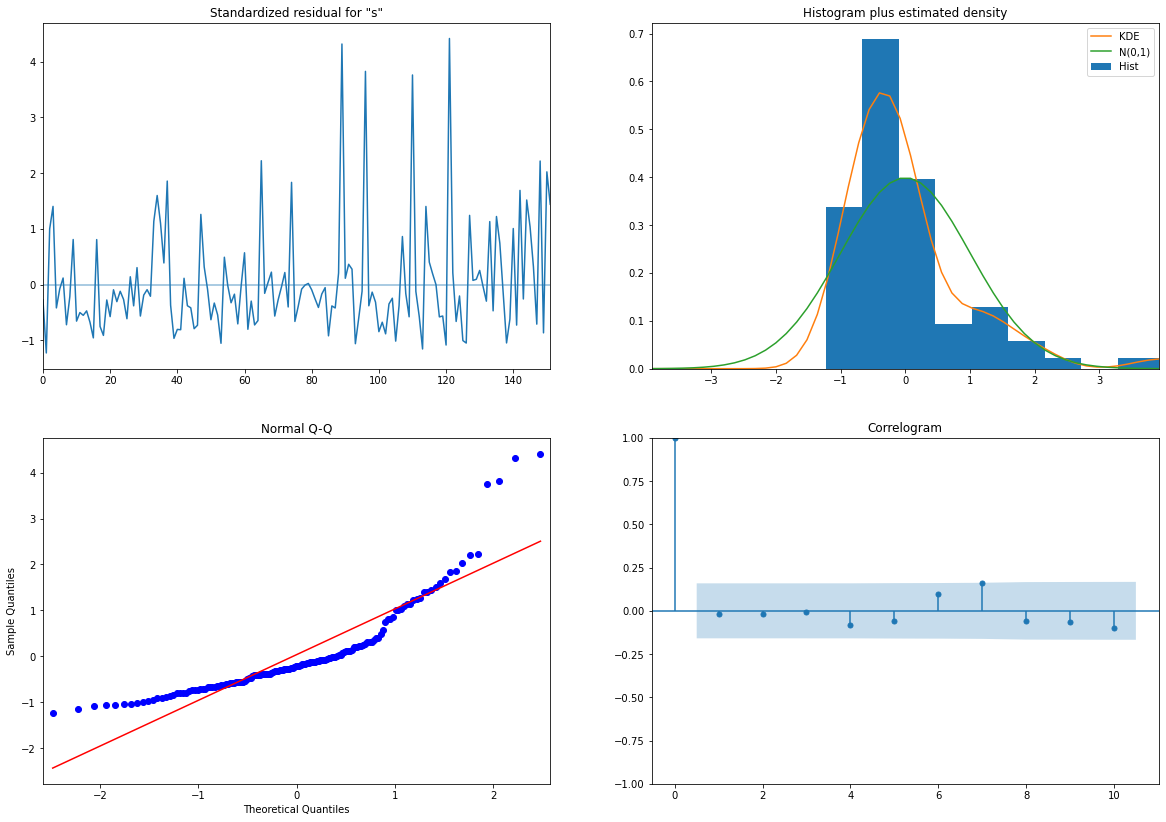

In [9]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()


In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [29]:
pred0 = results.get_prediction(start='2019-4-10',dynamic=False)
pred0_ci = pred1.conf_int()

In [30]:
pred1 = results.get_prediction(start='2019-4-10',dynamic=True)
pred1_ci = pred1.conf_int()

In [35]:
pred2 = results.get_forecast()
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2019-12-03':'2020-1-13'])
# print(pred2.predicted_mean[204:])

TypeError: cannot do slice indexing on RangeIndex with these indexers [2019-12-03] of type str

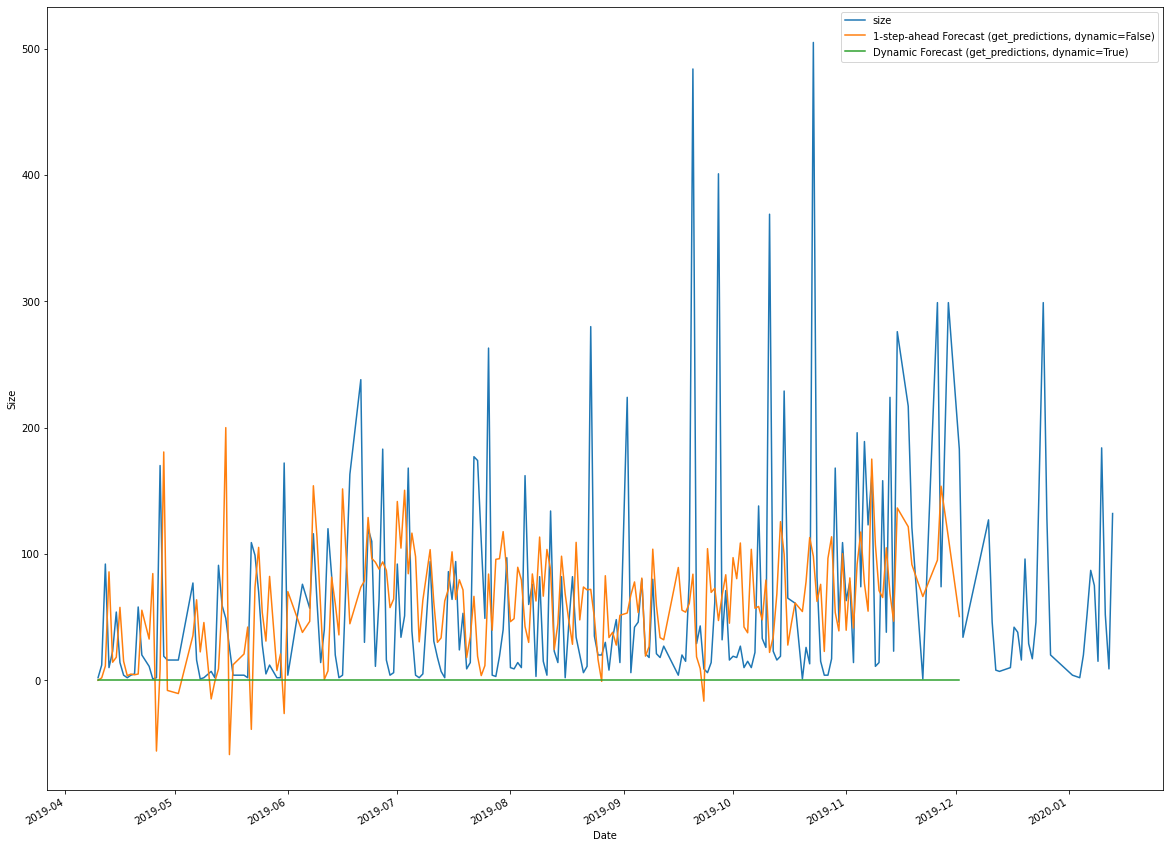

In [34]:
ax = df['size'].plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
plt.ylabel('Size')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# according to semi-month frequency to predict

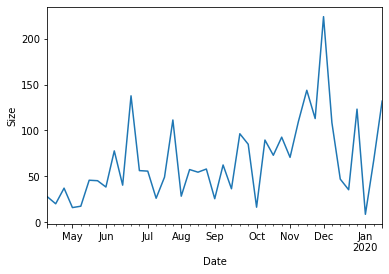

In [101]:
y = df["size"].resample('W').mean()
y = y.fillna(y.bfill())
# plot the data
y.plot()
plt.ylabel('Size')
plt.xlabel('Date')
plt.show()

In [102]:
print(y.index)

DatetimeIndex(['2019-04-14', '2019-04-21', '2019-04-28', '2019-05-05',
               '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02',
               '2019-06-09', '2019-06-16', '2019-06-23', '2019-06-30',
               '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28',
               '2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25',
               '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20',
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29', '2020-01-05', '2020-01-12',
               '2020-01-19'],
              dtype='datetime64[ns]', name='WBL_AUD_DT', freq='W-SUN')


In [103]:
split_date = '2019-11-24'
train_y = y[:split_date]
test_y = y[split_date:]
train_y

WBL_AUD_DT
2019-04-14     27.800000
2019-04-21     20.142857
2019-04-28     37.166667
2019-05-05     16.000000
2019-05-12     17.500000
2019-05-19     45.800000
2019-05-26     45.285714
2019-06-02     38.400000
2019-06-09     77.750000
2019-06-16     40.428571
2019-06-23    137.750000
2019-06-30     56.285714
2019-07-07     55.714286
2019-07-14     26.166667
2019-07-21     49.142857
2019-07-28    111.428571
2019-08-04     28.428571
2019-08-11     57.428571
2019-08-18     54.571429
2019-08-25     58.000000
2019-09-01     25.666667
2019-09-08     62.428571
2019-09-15     36.500000
2019-09-22     96.428571
2019-09-29     85.000000
2019-10-06     16.428571
2019-10-13     89.571429
2019-10-20     73.000000
2019-10-27     92.714286
2019-11-03     70.714286
2019-11-10    109.857143
2019-11-17    143.800000
2019-11-24    113.000000
Freq: W-SUN, Name: size, dtype: float64

In [104]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:365.7616749626633
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:229.75457277851189
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:215.8254380148881
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:90.76029723811246
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:227.78792159817783
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:220.00193699347898
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:101.00570390089233
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:92.72392455567515
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:92.47852913966149
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:94.47852914214398
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:6.0
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:8.0
SARIMAX(0, 0, 0)x(3, 0, 0, 12) - AIC:8.0
SARIMAX(0, 0, 0)x(3, 0, 1, 12) - AIC:10.0
SARIMAX(0, 0, 0)x(3, 1, 0, 12) - AIC:8.0
SARIMAX(0, 0, 0)x(3, 1, 1, 12) - AIC:10.0
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:342.53273529072067
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:213.68571990666888
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:208.00162167534182
SARIMAX(0, 0, 1)x(0, 1, 1, 12)

In [105]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 6.0 for model SARIMAX(0, 0, 0)x(2, 1, 0, 12)


In [118]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_y,
                                # order=SARIMAX_model[AIC.index(min(AIC))][0],
                                order=(0, 0, 1),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                size   No. Observations:                   33
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                   0.000
Date:                             Tue, 02 Mar 2021   AIC                              8.000
Time:                                     14:31:11   BIC                                nan
Sample:                                 04-14-2019   HQIC                               nan
                                      - 11-24-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0271         -0        inf      0.000      -0.027      -0.027
ar.S.L12            0         -0        nan        nan           0           0
ar.S.L24            0         -0        nan        nan           0           0
sigma2      2481.7081         -0       -inf      0.000    2481.708    2481.708
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [117]:

results.plot_diagnostics(figsize=(8, 12))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.